## 9.1 Stationary and differencing
A stationary time series is one whose statistical properties do not depend on the time at which the series is observed. This means time series with trends or with seasonality are not stationary.

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
sys.path.append('..')
from utils import *

In [2]:
from get_data import google, strikes, housing, us_econ, eggs, vic_pigs, lynx, aus_production, recent_production, a10

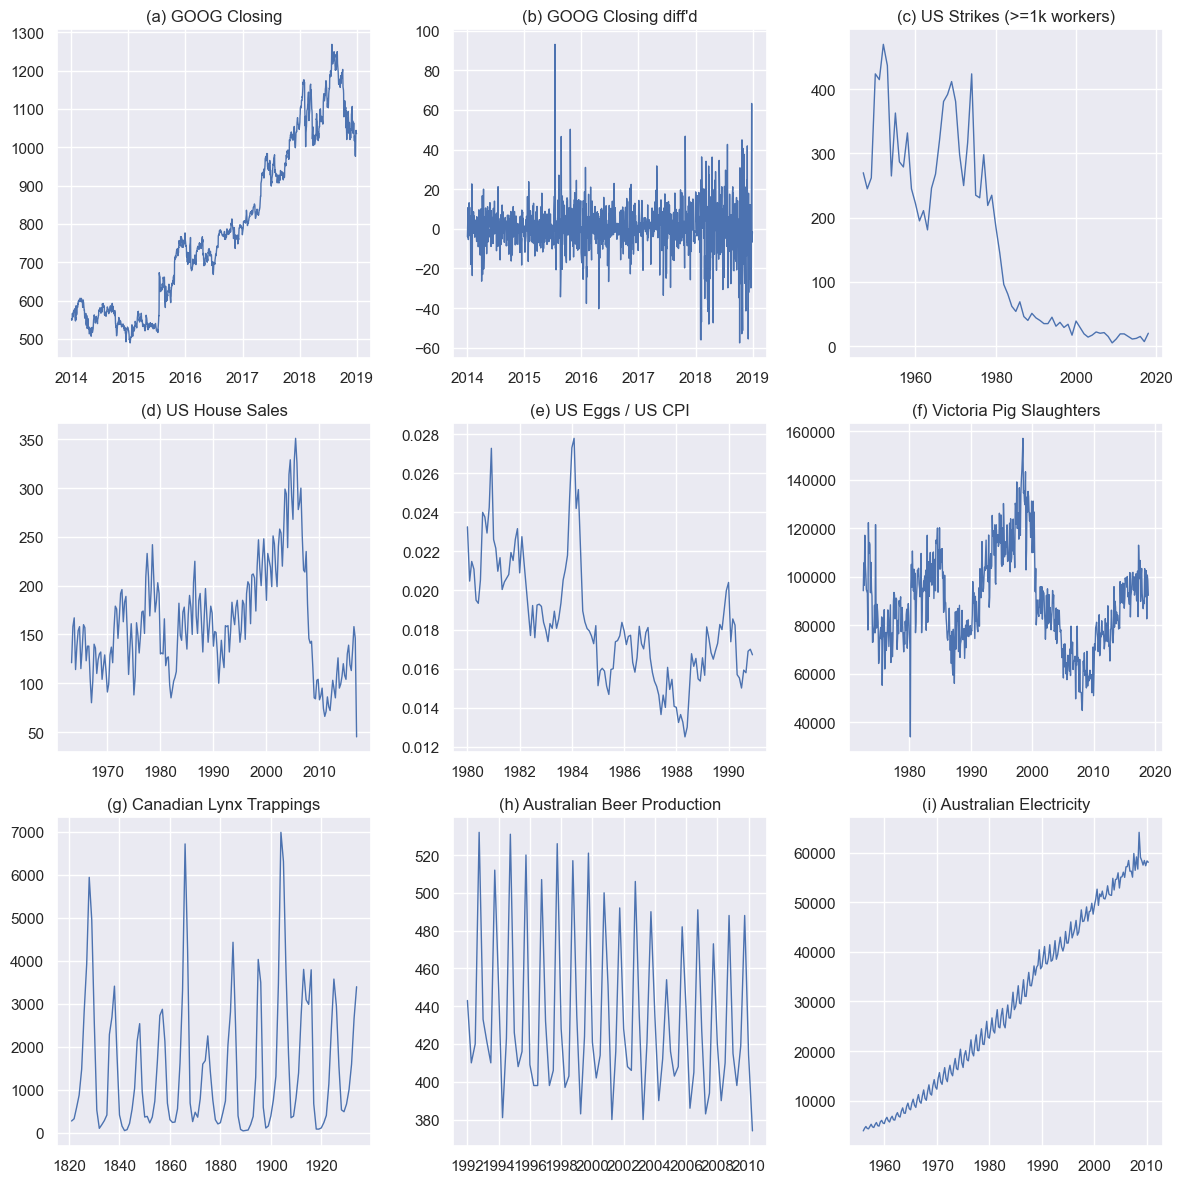

In [46]:
fig, axs = plt.subplots(3, 3, figsize=(12,12))
axs = axs.ravel()
axs[0].plot(google.Close)
axs[1].plot(google.Close.diff())

axs[2].plot(strikes.Year, strikes.Count)
axs[3].plot(housing.resample('1q').sum().Count)

axs[4].plot((eggs.EggPrice / eggs.CPI).loc[:'1990'])
axs[5].plot(vic_pigs.Count)

axs[6].plot(lynx.value)

axs[7].plot(recent_production.Beer)

axs[8].plot(aus_production.Electricity)

titles = [
    'GOOG Closing',
    'GOOG Closing diff\'d',
    'US Strikes (>=1k workers)',
    'US House Sales',
    'US Eggs / US CPI',
    'Victoria Pig Slaughters',
    'Canadian Lynx Trappings',
    'Australian Beer Production',
    'Australian Electricity',
]
for (ax, title, letter) in zip(axs, titles, 'abcdefghi'):
    ax.set(title=f'({letter}) {title}')
plt.tight_layout()

The only stationary series are (b) and (g). (g) has strong cycles but these are aperiodic, caused when lynx population becomes too large for the avilable feed, so they stop breeding and the population falls. In the long-term the timings of these cycles is not predictable, hence the series is stationary.

### Differencing
One way to make a non-stationary time series stationary is to compute the differences between consecutive observations. This is known as **differencing**. 

Transformations such as logarithms can help to stabilise the **variance** of a time series. Differencing can help stabilise the **mean** of a time series by removing changes in the level of a time series, and therefore eliminating (reducing) trend and seasonality.

The Autocorrelation plot is useful to identify non-stationary time series. For a stationary time series, the autocorrelation will drop to zero relatively quickly, while the autocorrelation of non-stationary data decreases slowly. Also for non-stationary data, the value of $r_1$ is often large and positive.

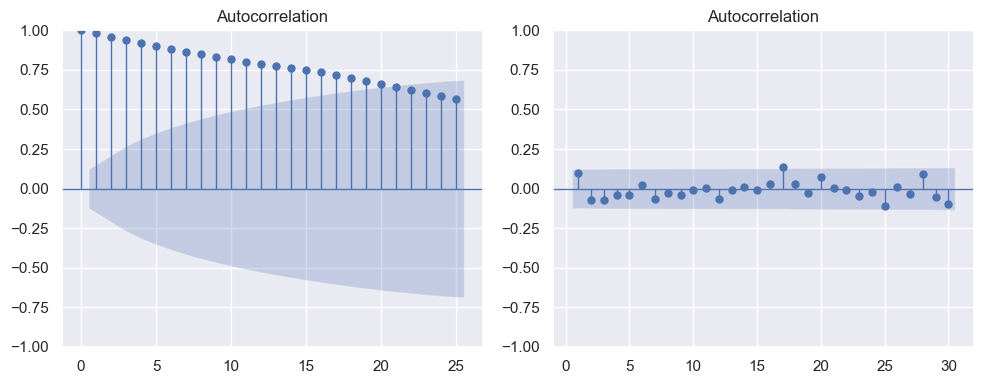

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
google_15 = google['2015':'2015']
sm.graphics.tsa.plot_acf(google_15['Close'], ax=axes[0])
sm.graphics.tsa.plot_acf(google_15['Close'].diff().dropna(), lags=np.r_[1:31], ax=axes[1])
plt.tight_layout()

The ACF of the differenced Google stock price looks just like that of a white noise series. Only one autocorrelation is outside the 95% limits, and we can calculate the [Ljung-Box $Q^*$ statistics](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html) to test for autocorrelation in residuals. This has a $p$-value of 0.653 for ($h=10$). This suggests that the *daily change* in the Google stock price is essentially a random amount which is uncorrelated with that of previous days. 

In [52]:
sm.stats.acorr_ljungbox(
    google_15["Close"].diff().dropna(), lags=[10], boxpierce=True, return_df=True
)


,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,7.914143,0.637223,7.744517,0.653776


### Random walk model
The differenced series is the *change* between consecutive observations in the original series. When the differenced series is white noise, the model for the original series can be written as
$$
y_t - y_{t-1} = \epsilon_t,
$$
where $\epsilon_t$ denotes white noise. Rearranging this leads to the "random walk" model
$$
y_t = y_{t-1} + \epsilon_t.
$$
Random walk models are widely used for non-stationary data, particularly financial and economic data. Random walks typically have:
- long periods of apparent trends up or down
- sudden and unpredictable changes in direction.

The forecasts from a random walk model are equal to the last observation, as future movements are unpredictable, and are equally likely to be up or down. Thus, the random walk model underpins naïve forecasts.

A closely related model allows the differences to have a non-zero mean. Then
$$
y_t - y_{t-1} = c + \epsilon_t \quad\text{or}\quad y_t = c + y_{t-1} + \epsilon_t.
$$
The value of $c$ is the average of the changes between consecutive observations. If $c$ is positive, then the average change is an increase in the value of $y_t$. Thus, $y_t$ will tend to drift upwards. However, if $c$ is negative, $y_t$ will tend to drift downwards. This is the model behind the drift method.


### Second-order differencing
It might be necessary to difference the data a second time to obtain a stationary series.
$$
y_t'' = y_t - 2y_{t-1} + y_{t-2}
$$
$y_t''$ will have $T-2$ values. 

### Seasonal differencing
A seasonal difference is the difference between an observation and the previous observation from the same season. So
$$
y_t' = y_t - y_{t-m},
$$
where $m=$ the number of seasons.

If seasonally differenced data appear to be white noise, then an appropriate model for the original data is
$$
y_t = y_{t-m} + \epsilon_t.
$$
Forecasts from this model are equal to the last observation from the relevant season. That is, this model gives seasonal naïve forecasts.

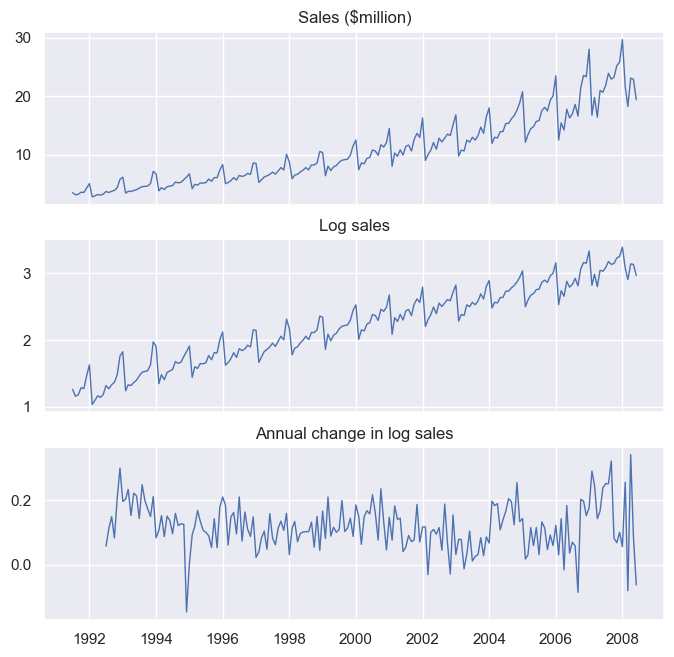

In [58]:
fig, axes = plt.subplots(3, 1, figsize=(8, 7), sharex=True)
axes[0].plot(a10.Cost)
axes[1].plot(np.log(a10.Cost))
axes[2].plot(np.log(a10.Cost).diff(12))
titles = 'Sales ($million)', 'Log sales', 'Annual change in log sales'
for ax, title in zip(axes, titles):
    ax.set(title=title)
fig.subplots_adjust(top=0.95)

Another example of seasonal differencing:

In [67]:
from get_data import PBS

In [68]:
h02 = (
    PBS
    .query('ATC2 == "H02"')
    .groupby('Month', sort=False)
    .pipe(summarize, lambda x: dict(Cost = x.Cost.sum() / 1e6))
    .reset_index()
    .set_index('Month', drop=False)
)

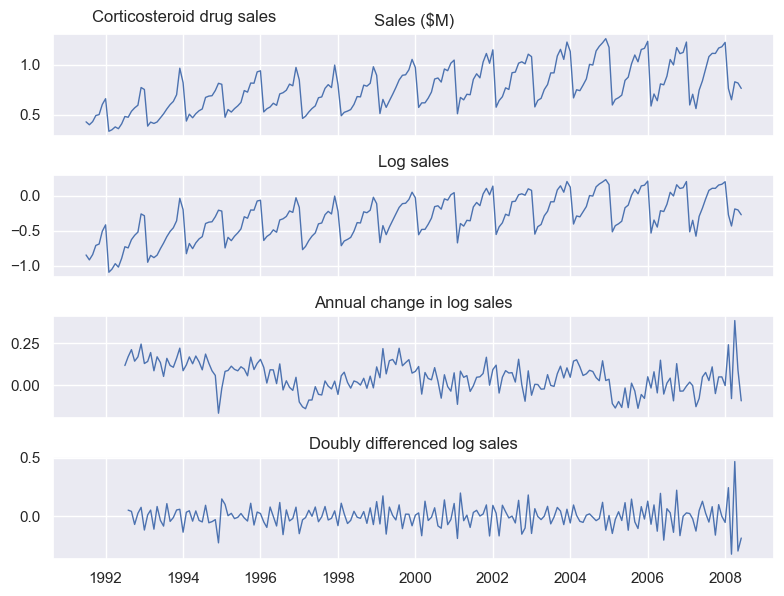

In [75]:
fig, axs = plt.subplots(4, 1, figsize=(8,6), sharex=True)
axs[0].plot(h02.Cost)
axs[1].plot(np.log(h02.Cost))
axs[2].plot(np.log(h02.Cost).diff(12))
axs[3].plot(np.log(h02.Cost).diff(12).diff())
titles = 'Sales ($M)', 'Log sales', 'Annual change in log sales', 'Doubly differenced log sales'
for (ax, title) in zip(axs, titles):
    ax.set(title=title)
fig.text(fig.subplotpars.left, .99, 'Corticosteroid drug sales', ha='left', va='top')
plt.tight_layout()
fig.subplots_adjust(top=.95)

### Unit root tests
One way to determine more objectively whether differencing is required is to use a *unit root test*. These are statistical hypothesis tests of stationarity that are designed for determining whether differencing is required.

A number of unit root tests are available, which are based on different assumptions and may lead to conflicting answers. In this analysis, we use the [Kwiatkowski-Phillips-Schmidt-Shin (KPSS)](https://en.wikipedia.org/wiki/KPSS_test) test.  In this test, the null hypothesis is that the data are stationary, and we look for evidence that the null hypothesis is false. Consequently, small $p$-values (e.g., less than 0.05) suggest that differencing is required.


In [76]:
sm.tsa.stattools.kpss(google_15['Close'], nlags='auto')

(np.float64(2.0093692755932886),
 np.float64(0.01),
 10,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

The KPSS test $p$-value is reported as a number between 0.01 and 0.1. If the actual $p$-value is less than 0.01 then it is reported as 0.01; and if the actual $p$-value is greater than 0.1 it is reported as 0.1. In this case, the $p$-value is shown as 0.01, indicating the null hypothesis is rejected. i.e. the data are not stationary. If we apply the test on the differenced data, we get:

In [77]:
sm.tsa.stattools.kpss(google_15['Close'].diff().dropna(), nlags='auto')

(np.float64(0.09886690003792759),
 np.float64(0.1),
 5,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

This time the $p$-value is reported as 0.1. We can conclude that the differenced data appear stationary.